### 1. Загрузка датасета и первичный анализ

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
df = pd.read_csv('claims_sample_data.csv', header=0, sep=',')
df.head()

,MONTH,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,PAID_AMOUNT
0,201801,AncillaryFFS,NaN,Payer F,4281
1,201801,AncillaryFFS,NaN,Payer H,2221
2,201801,AncillaryFFS,NaN,Payer O,3937
3,201801,AncillaryFFS,NaN,Payer W,268
4,201801,AncillaryFFS,ACH,Payer W,151


In [247]:
df.shape

(52152, 5)

In [248]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52152 entries, 0 to 52151
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   MONTH             52152 non-null  int64 
 1   SERVICE_CATEGORY  52152 non-null  object
 2   CLAIM_SPECIALTY   51901 non-null  object
 3   PAYER             52152 non-null  object
 4   PAID_AMOUNT       52152 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 2.0+ MB


In [249]:
df.duplicated().sum()

0

In [250]:
df.describe()

,MONTH,PAID_AMOUNT
count,52152.000000,5.215200e+04
mean,201885.029567,3.708707e+03
std,72.867005,3.449842e+04
min,201801.000000,-4.223000e+04
25%,201808.000000,1.940000e+02
50%,201903.000000,5.860000e+02
75%,201911.000000,1.465000e+03
max,202007.000000,2.268611e+06


В исходном датафрейме значения CLAIM_SPECIALITY местами не заданы. Проверим остальные измерения на пустые значения и заменим пропуски на "Not specified"

In [251]:
print(f"Пустых значений в столбце MONTH: {df[df['MONTH'].isnull()].shape[0]}")
print(f"Пустых значений в столбце SERVICE_CATEGORY: {df[df['SERVICE_CATEGORY'].isnull()].shape[0]}")
print(f"Пустых значений в столбце CLAIM_SPECIALTY: {df[df['CLAIM_SPECIALTY'].isnull()].shape[0]}")
print(f"Пустых значений в столбце PAYER: {df[df['PAYER'].isnull()].shape[0]}")

Пустых значений в столбце MONTH: 0
Пустых значений в столбце SERVICE_CATEGORY: 0
Пустых значений в столбце CLAIM_SPECIALTY: 251
Пустых значений в столбце PAYER: 0


In [252]:
df['CLAIM_SPECIALTY'] = df['CLAIM_SPECIALTY'].fillna('Not specified')
df.head()

,MONTH,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,PAID_AMOUNT
0,201801,AncillaryFFS,Not specified,Payer F,4281
1,201801,AncillaryFFS,Not specified,Payer H,2221
2,201801,AncillaryFFS,Not specified,Payer O,3937
3,201801,AncillaryFFS,Not specified,Payer W,268
4,201801,AncillaryFFS,ACH,Payer W,151


Судя по выводу команды .describe() в столбце с суммой требования к страховой комании есть отрицательные значения. Проверим количество таких строк 

In [253]:
df[df['PAID_AMOUNT'] < 0].shape[0]
#df[df['PAID_AMOUNT'] < 0].head(10)

325

Согласно описанию датасета, столбец PAID_AMOUNT содержит сумму требований со стороны медицинских учреждений в сторону страховых компаний. Теоретически, отрицательная сумма может возникать в случае корректировок, однако из описания датасета это не следует. Количество строк с отрицательной суммой выплаты менее 1% от размера датасета, поэтому будем считать это ошибочными данными, которые следует исключить из дальнейшего анализа

In [254]:
df.drop(df[df['PAID_AMOUNT'] < 0].index, inplace = True)
df[df['PAID_AMOUNT'] < 0].head(10)

,MONTH,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,PAID_AMOUNT


In [255]:
df.shape

(51827, 5)

Напоследок введем столбец REPORT_DT в который запишем отчетную дату в более "привычном" формате. Сначала посмотрим, какие даты встречаются в файле.

In [256]:
df['MONTH'].unique()

array([201801, 201802, 201803, 201804, 201805, 201806, 201807, 201808,
       201809, 201810, 201811, 201812, 201900, 201901, 201902, 201903,
       201904, 201905, 201906, 201907, 201908, 201909, 201910, 201911,
       201912, 202001, 202002, 202003, 202004, 202005, 202006, 202007],
      dtype=int64)

In [257]:
df[df['MONTH'] == 201900].shape[0]

4

Значение "201900" явно ошибочное, исключим его из датасета

In [258]:
df.drop(df[df['MONTH'] == 201900].index, inplace = True)

In [259]:
df['REPORT_DT'] = pd.to_datetime(df['MONTH'], format='%Y%m')

In [260]:
df.head()

,MONTH,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,PAID_AMOUNT,REPORT_DT
0,201801,AncillaryFFS,Not specified,Payer F,4281,2018-01-01
1,201801,AncillaryFFS,Not specified,Payer H,2221,2018-01-01
2,201801,AncillaryFFS,Not specified,Payer O,3937,2018-01-01
3,201801,AncillaryFFS,Not specified,Payer W,268,2018-01-01
4,201801,AncillaryFFS,ACH,Payer W,151,2018-01-01


### 2. Изучение распределения данных в разрезе измерений

In [261]:
df.nunique()

MONTH                 31
SERVICE_CATEGORY      10
CLAIM_SPECIALTY      906
PAYER                 10
PAID_AMOUNT         7676
REPORT_DT             31
dtype: int64

Изучим распределение данных в разрезе измерений: SERVICE_CATEGORY, CLAIM_SPECIALITY, PAYER

##### 2.1 Измерение SERVICE_CATEGORY

In [262]:
df["SERVICE_CATEGORY"].unique()

array(['AncillaryFFS', 'ASCServices', 'ERServices', 'InpatientServices',
       'OutpatientServices', 'PCPEncounter', 'PCPFFS', 'SNFServices',
       'SpecialistFFS', 'SpecialistsFFS'], dtype=object)

Обратим внимание на наличие 2 очень похожих по названию категорий: 'SpecialistFFS' и 'SpecialistsFFS'. Возможно, имеет место ошибка на этапе сбора и классификации данных и эти две категории следует объединить в одну.

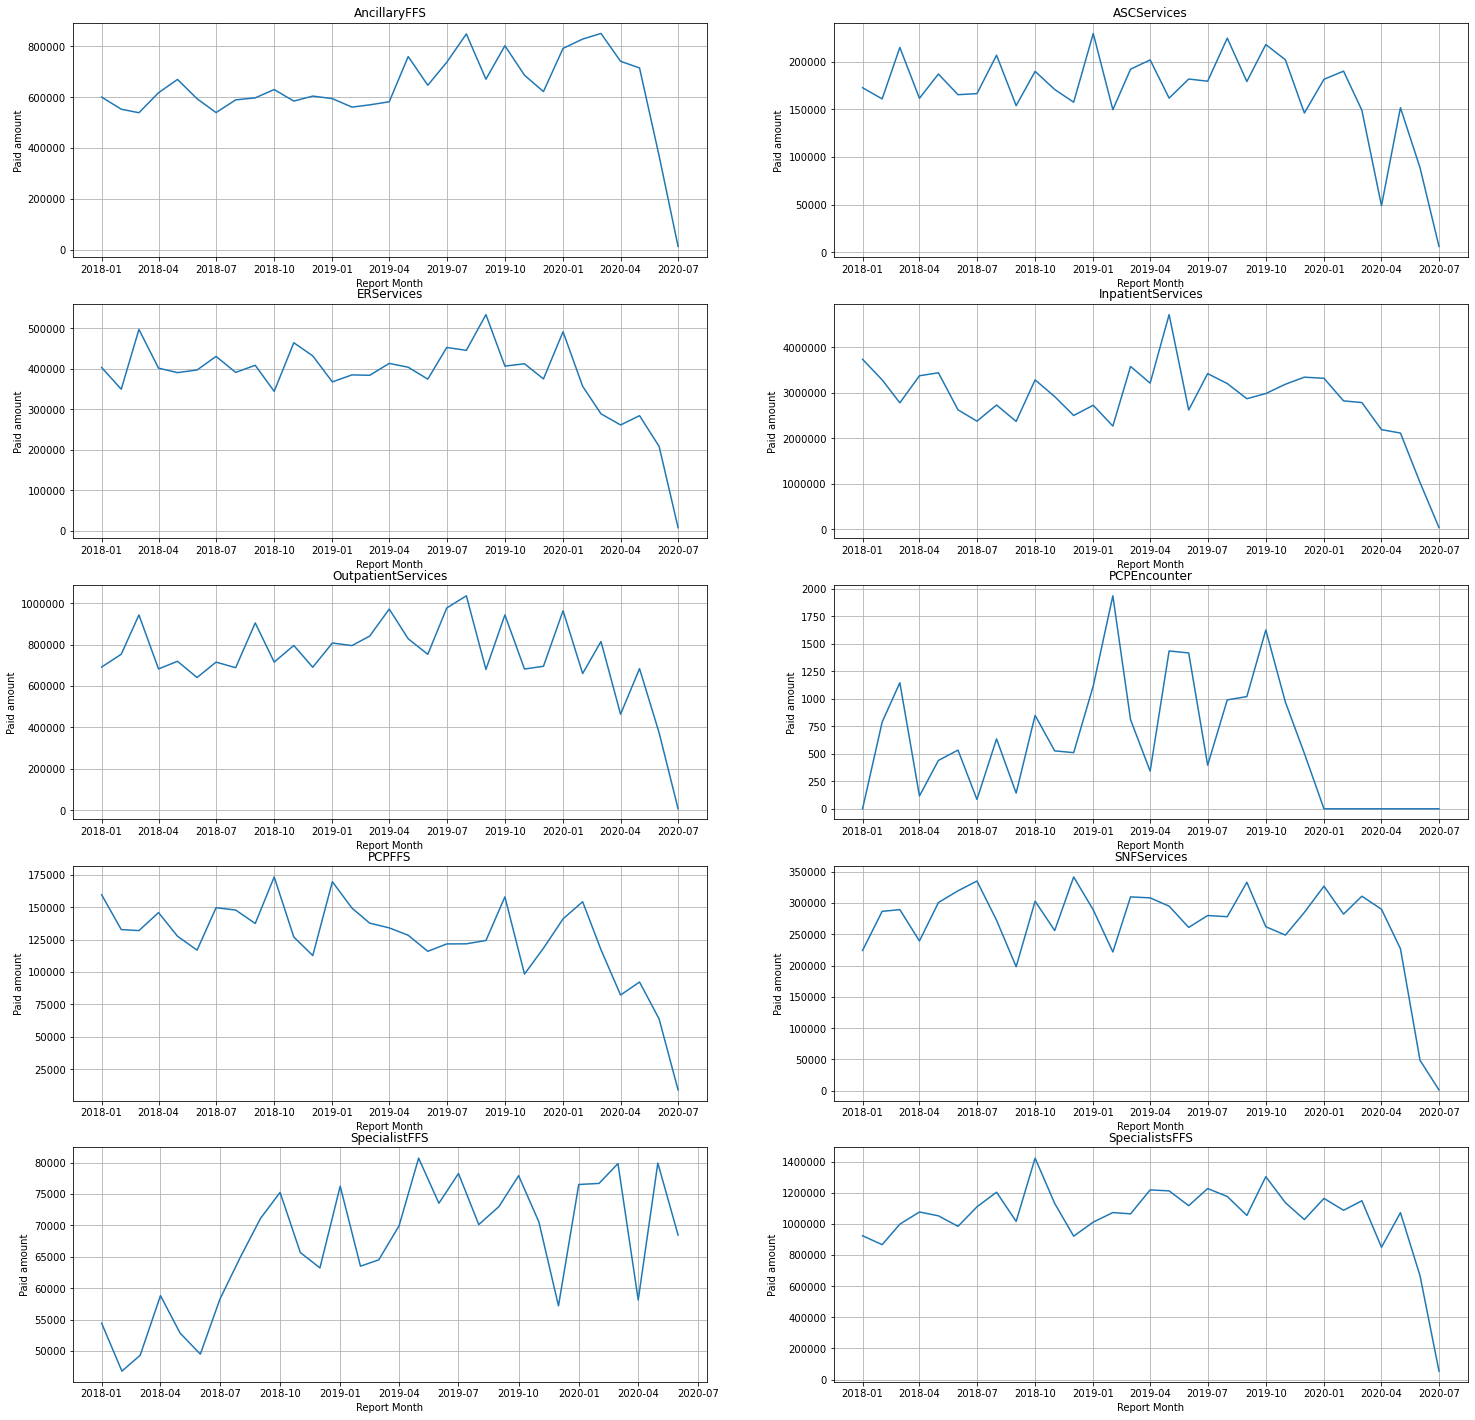

In [263]:
i = 1
plt.figure(figsize=(25, 25))
for cat in df["SERVICE_CATEGORY"].unique():
    dfi = df[df['SERVICE_CATEGORY'] == cat]
    dfi = dfi.set_index('REPORT_DT')
    dfi = dfi.drop(['MONTH', 'SERVICE_CATEGORY', 'CLAIM_SPECIALTY', 'PAYER'], axis=1)
    plt.subplot(5,2,i)
    sns.lineplot(x=dfi.index, y=dfi['PAID_AMOUNT'], ci=None, estimator=sum) 
    plt.ticklabel_format(style='plain', axis='y')
    plt.xlabel('Report Month') 
    plt.ylabel('Paid amount') 
    plt.title(cat) 
    plt.grid(True) 
    i = i + 1
plt.show()

На графиках заметно, что требуемая сумма оплаты по некоторым категориям в последние месяцы наблюдений сильно сокращалась. Тененция к падению заметна для категорий 'AncillaryFFS', 'ERServices', 'InpatientServices', 'OutpatientServices', 'PCPEncounter', 'SNFServices', причем для категории 'PCPEncounter' сумма требований равна 0 последние несколько месяцев. Это может быть связано как со снижением спроса на услуги данных категорий, так и с недостаточностью и низким качеством данных (следовательно, полноту данных по этим категориям следует проверить)

In [264]:
df_cat = df.drop(['MONTH', 'CLAIM_SPECIALTY', 'PAYER'], axis=1).groupby(['REPORT_DT','SERVICE_CATEGORY'], group_keys=False).sum().unstack().fillna(0)
df_cat = df_cat.reindex()

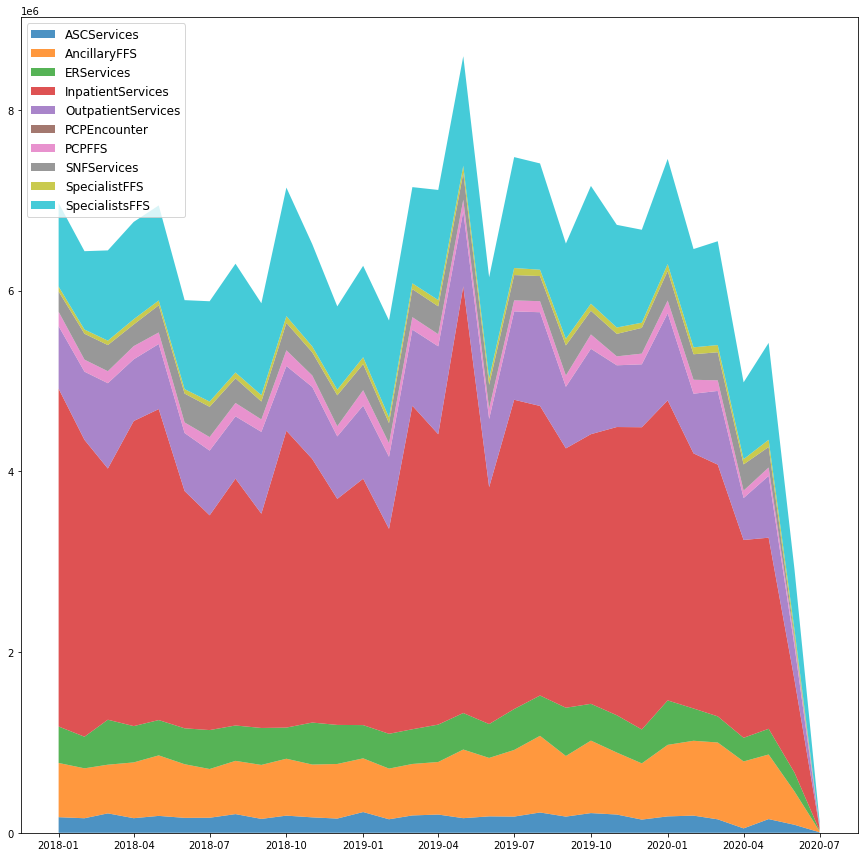

In [265]:
plt.figure(figsize=(15, 15))
plt.stackplot(df_cat.index,
              [df_cat[('PAID_AMOUNT',  'ASCServices')], df_cat[('PAID_AMOUNT',  'AncillaryFFS')],
               df_cat[('PAID_AMOUNT',  'ERServices')], df_cat[('PAID_AMOUNT',  'InpatientServices')],
               df_cat[('PAID_AMOUNT',  'OutpatientServices')], df_cat[('PAID_AMOUNT',  'PCPEncounter')],
               df_cat[('PAID_AMOUNT',  'PCPFFS')], df_cat[('PAID_AMOUNT',  'SNFServices')],
               df_cat[('PAID_AMOUNT',  'SpecialistFFS')], df_cat[('PAID_AMOUNT',  'SpecialistsFFS')]],
              labels=['ASCServices', 'AncillaryFFS', 'ERServices', 'InpatientServices', 'OutpatientServices', 'PCPEncounter', 'PCPFFS', 'SNFServices', 'SpecialistFFS', 'SpecialistsFFS'],
              alpha=0.8)

plt.legend(loc=2, fontsize='large')

Структура денежных требований в разрезе категории услуг (измерения SERVICE_CATEGORY) со временем практически не меняется, наибольшую долю в сумме требований к старховым компаниям стабильно занимают категории "InpatientServices", "SpecialistFFS" и "OutpatientServices"

##### 2.2 Измерение CLAIM_SPECIALITY

In [266]:
df['CLAIM_SPECIALTY'].unique()

array(['Not specified', 'ACH', 'Advanced Registered Nurse Prac',
       'ADVANCED RN PRACT', 'AMBULANCE', 'Ambulance', 'AMBULANCE SERVICE',
       'AMBULATORY SURGICAL CENTER', 'Ambulatory Transportation Services',
       'ANATOM', 'ANESTHESIOLOGY', 'ARNP', 'BEHAVIORAL HEALTH COUNSELING',
       'CARD ELECTROPHYSIOLO', 'CARDIAC ELECTROPHYSIOLOGY', 'CARDIOLOGY',
       'Cardiology/Cardiovascular Disease', 'Cardiovascular Medicine',
       'CARDIOVASCULAR SURGERY', 'CCS', 'Chiropractic Medicine',
       'Clinical Medical Laboratory\t', 'Colon and Rectal Surgery',
       'COMMUNITY MENTAL HEALTH CENTER',
       'COMMUNITY MENTAL HEALTH CENTER/OTHER REHAB CENTER',
       'CONV CARE CLINIC', 'COVERING PHYSICIAN', 'CRITICAL ACCESS', 'CSW',
       'DEFAULT', 'Dermatology', 'DERMATOLOGY', 'DERMATOPATHOLOGY',
       'Dermatopathology', 'DIABETES EDUCATOR', 'DIAG X-RAY CLINIC',
       'DIAGNOSTIC RADIOLOGY', 'Diagnostics', 'DIAL', 'DIALYSIS',
       'Dialysis', 'DIALYSIS CENTER', 'DISEASE MANAGE

При попытке анализа данных в разрезе медицинской специальности (в разрезе измерения CLAIM_SPECIALITY) проблема качества данных становится очевидной:
* в данных есть пропуски, которые мы ранее заменили на значение Not Specified
* есть очевидно одинаковые специальности, записанные в разных регистрах или сформулированные по-разному (например, 'AMBULANCE', 'Ambulance', 'AMBULANCE SERVICE')
* значение 'ERROR' скорее всего соответствует ошибке классификации

Для дальнейшего анализа следует исправить проблемы Data Quality и привести измерение CLAIM_SPECIALITY к корректному классификатору специальностей, возможно, дополнив его значением "Not Specified" или "Other" для случаев, когда восстановить корректную специальность невозможно

##### 2.2 Измерение PAYER

In [267]:
df['PAYER'].unique()

array(['Payer F', 'Payer H', 'Payer O', 'Payer W', 'Payer UN', 'Payer CA',
       'Payer CO', 'Payer S', 'Payer B', 'Payer UL'], dtype=object)

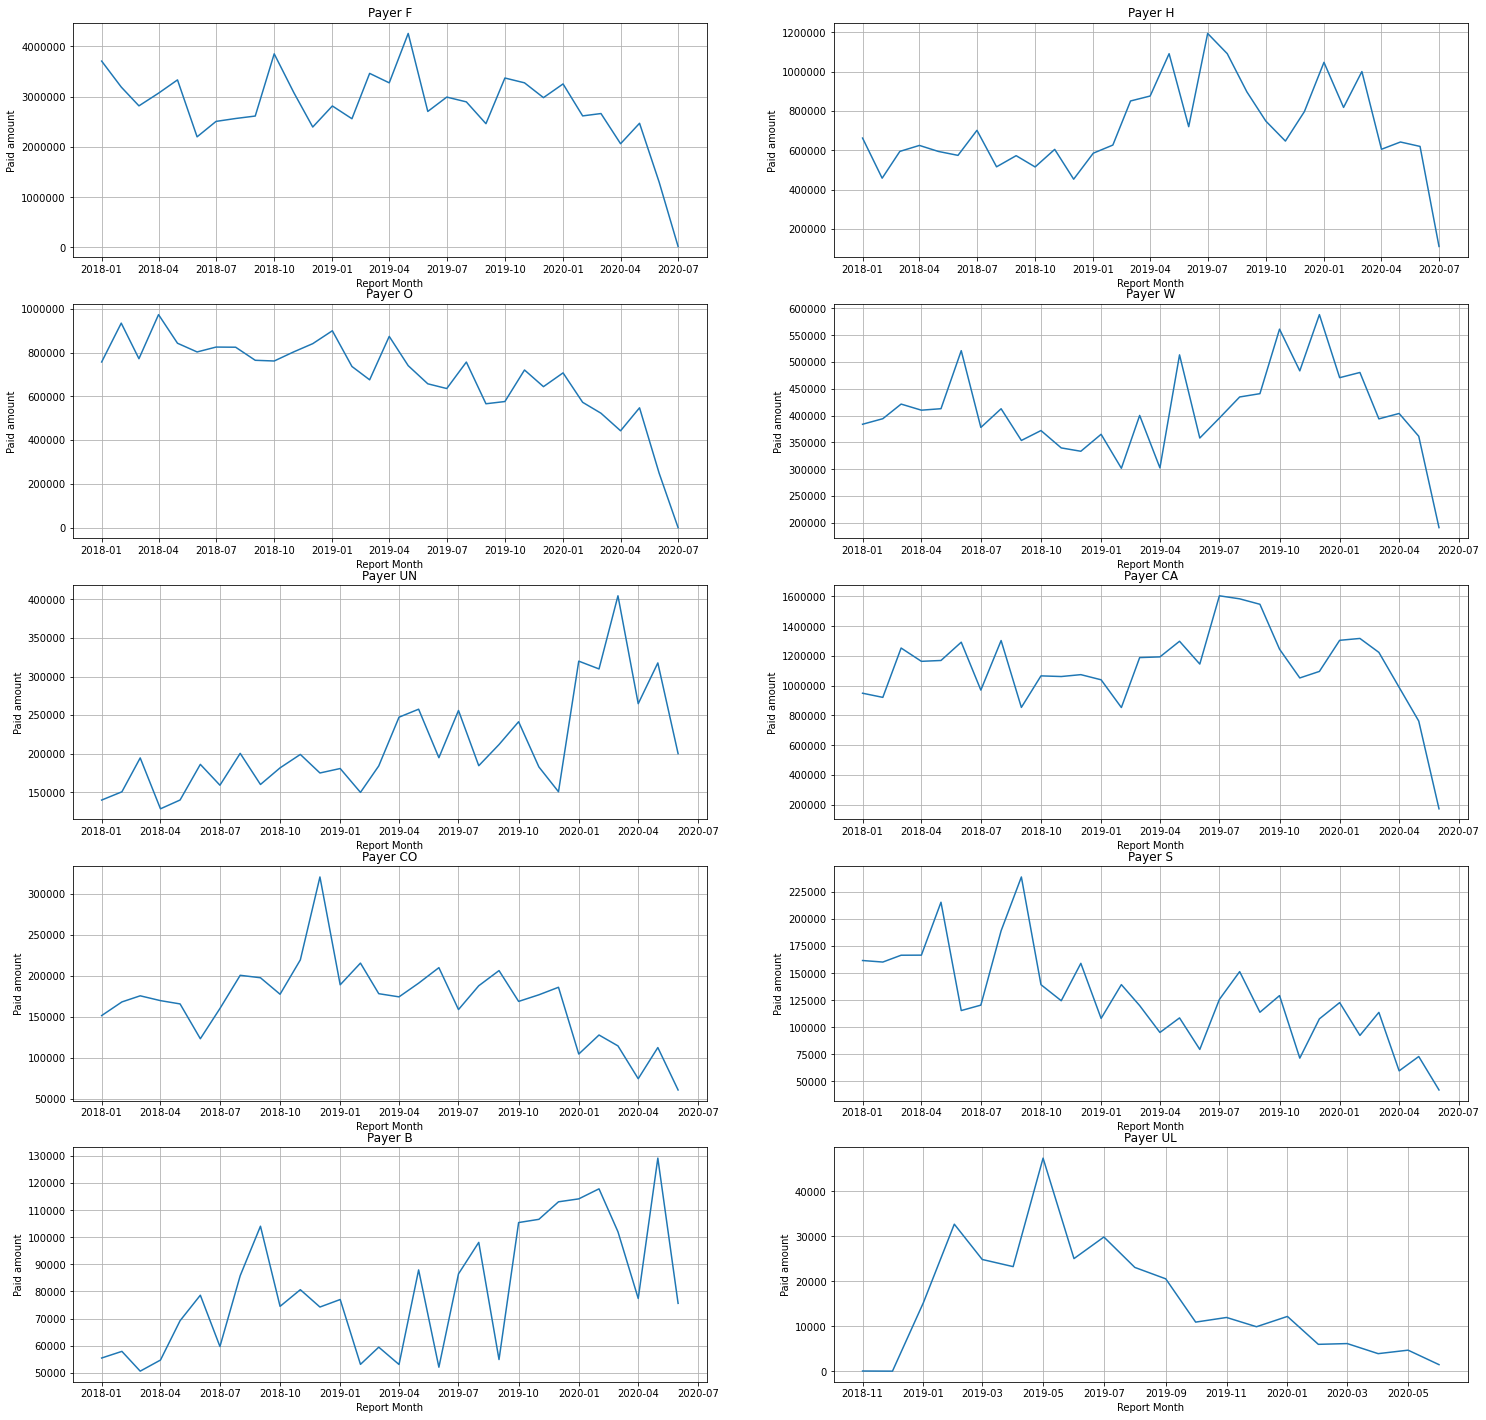

In [268]:
i = 1
plt.figure(figsize=(25, 25))
for cat in df["PAYER"].unique():
    dfi = df[df['PAYER'] == cat]
    dfi = dfi.set_index('REPORT_DT')
    dfi = dfi.drop(['MONTH', 'SERVICE_CATEGORY', 'CLAIM_SPECIALTY'], axis=1)
    plt.subplot(5,2,i)
    sns.lineplot(x=dfi.index, y=dfi['PAID_AMOUNT'], ci=None, estimator=sum) 
    plt.ticklabel_format(style='plain', axis='y')
    plt.xlabel('Report Month') 
    plt.ylabel('Paid amount') 
    plt.title(cat) 
    plt.grid(True) 
    i = i + 1
plt.show()

Данные по страховым компаниям "Payer F" и "Payer O" в конце периода наблюдений падают до 0, что скорее всего свидетельствует об отсутствии данных за последний месяц наблюдений. Для данных по требованиям к страховым компаниям Payer H, Payer W, Payer CA также характерно резкое падение значений в конце наблюдаемого периода, что может свидетельствовать о проблемах с данными. Сумма требований к страховым компаниям Payer CO, Payer S, Payer UL устойчиво снижается последние несколько месяцев

In [269]:
df_payer = df.drop(['MONTH', 'CLAIM_SPECIALTY', 'SERVICE_CATEGORY'], axis=1).groupby(['REPORT_DT','PAYER'], group_keys=False).sum().unstack().fillna(0)
df_payer = df_payer.reindex()

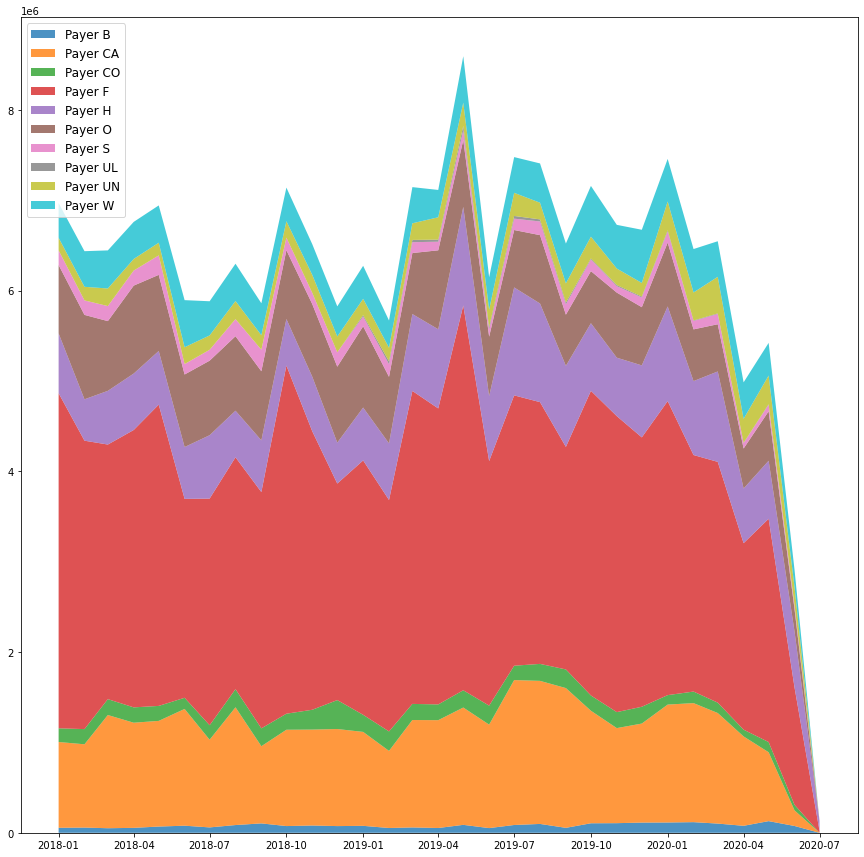

In [270]:
plt.figure(figsize=(15, 15))
plt.stackplot(df_payer.index,
              [df_payer[('PAID_AMOUNT',  'Payer B')], df_payer[('PAID_AMOUNT',  'Payer CA')],
               df_payer[('PAID_AMOUNT',  'Payer CO')], df_payer[('PAID_AMOUNT',  'Payer F')],
               df_payer[('PAID_AMOUNT',  'Payer H')], df_payer[('PAID_AMOUNT',  'Payer O')],
               df_payer[('PAID_AMOUNT',  'Payer S')], df_payer[('PAID_AMOUNT',  'Payer UL')],
               df_payer[('PAID_AMOUNT',  'Payer UN')], df_payer[('PAID_AMOUNT',  'Payer W')]],
              labels=['Payer B', 'Payer CA', 'Payer CO', 'Payer F', 'Payer H', 'Payer O', 'Payer S', 'Payer UL', 'Payer UN', 'Payer W'],
              alpha=0.8)

plt.legend(loc=2, fontsize='large')

Структура требований в разрезе страховых компаний также достаточно стабильна, наибольшая сумма требований предъявляется к компаниям Payer F и Payer CA

### 3. Анализ временного ряда и прогнозирование показателя

Ниже предпринята попытка применить к датасету методы анализа временных рядов. Аналогичная методика может быть применена для прогнозирования значений в разрезе каждого из возможных измерений, например, для прогнозирования объема требований к конкретной страховой компании или по конкретной категории услуги.

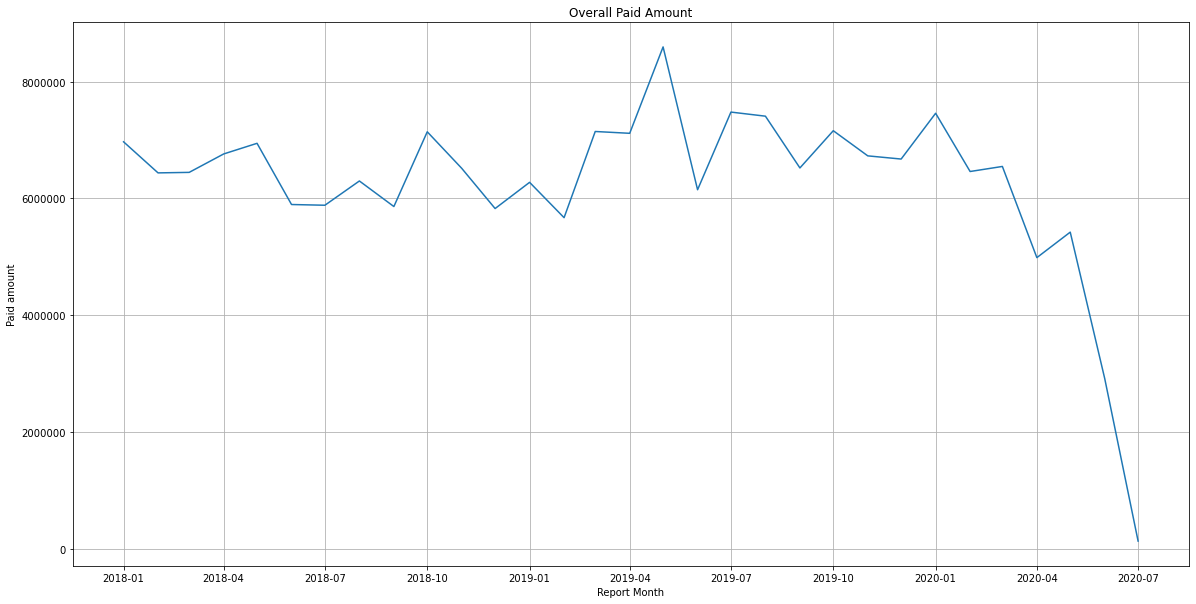

In [143]:
data = df[['REPORT_DT', 'PAID_AMOUNT']]
plt.figure(figsize=(20, 10))
sns.lineplot(x=data['REPORT_DT'], y=data['PAID_AMOUNT'], ci=None, estimator=sum) 
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Report Month') 
plt.ylabel('Paid amount') 
plt.title('Overall Paid Amount') 
plt.grid(True) 
plt.show()

В последних 2 месяцах, скорее всего, не хватает данных, что может негативно сказаться на результатах моделирования. Исключим их из рассмотрения

In [172]:
data = df[['REPORT_DT', 'PAID_AMOUNT']]
data = data.groupby(by=['REPORT_DT'], as_index=False).sum()
data = data[data['REPORT_DT'] <= '2020-05-01']

Из визуального анализа можно сделать вывод об отсутствии выраженного тренда и сезонности. Проверим стационарность формально с помощью критерия Дики-Фуллера и заодно посмотрим на результаты STL-декомпозиции

In [180]:
import statsmodels.api as sm
#data = data.set_index('REPORT_DT')
#plt.figure(figsize=(10,5))
#sm.tsa.seasonal_decompose(x=data['PAID_AMOUNT']).plot()

In [178]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.PAID_AMOUNT)[1])

Критерий Дики-Фуллера: p=0.002046


Достигаемый уровень значимости < 1%, следовательно мы можем с уровнем значимости 99% отклонить гипотезу о нестационарности временного ряда. В случае стационарного ряда дополнительные манипуляции вроде стабилизации дисперсии или дифференцирования не требуются. Посмотрим на ACF и PACF полученного ряда

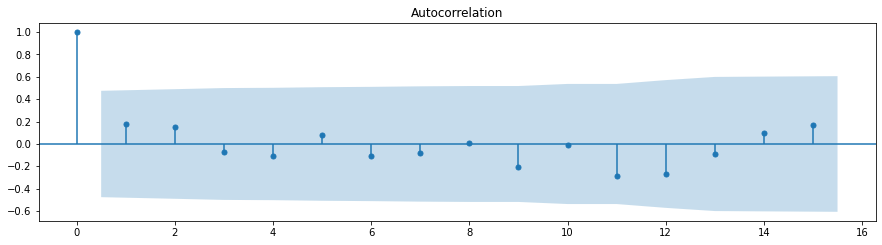

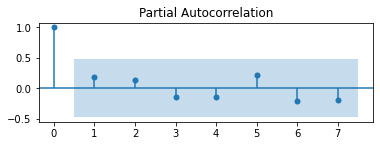

In [239]:
plt.figure(figsize=(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.PAID_AMOUNT[12:].values.squeeze(), lags=15, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.PAID_AMOUNT[12:].values.squeeze(), lags=7, ax=ax)
plt.show()

Таким образом, наш временной ряд стационарен, зависимость членов ряда от предыдущих значений незначима. В этом случае наилучшим прогнозом будет колебание вокруг среднего значения

In [244]:
print(f"Среднее значение показателя: ${data.PAID_AMOUNT.mean()}")
print(f"Среднеквадратическое отклонение показателя: ${data.PAID_AMOUNT.sem()}")

Среднее значение показателя: $6577268.137931035
Среднеквадратическое отклонение показателя: $136343.89247135606


In [243]:
import scipy.stats as st
st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)) 

(array([6297980.33485255]), array([6856555.94100952]))

Таким образом, с 95% вероятностью ежемесячные значения сумм истребования у страховых компаний до конца 2020 года составит от $6'297'980.33 до $6'856'555.94